<center>Hans Christian Sundsfjord</center>

# Intelligente systemer: Maskinlæringsutfordringen
Velkommen til denne Jupyter notebooken, som du skal bruke til den obligatoriske innsendingsoppgaven i Høyskolen Kristianias emne «Utvikling og anvendelse av intelligente systemer».

## Hvordan du bruker denne notebooken 
Du skal gå gjennom denne notebooken for å løse innsendingsoppgaven. Undervis skal du skrive kode som løser kodeoppgavene skrevet _i kursiv_. Skriv kode inn i kodecellen rett under oppgaven, og legg gjerne til flere kodeceller. Du kan finne og gjenbruke relevant kode i notebooks i emnets modul 1, 2 og 3, og her i oppgaveteksten. Du kan eventuelt bruke andre programmeringsspråk etter avtale med veilederen din, men alle kodehint er gitt for Python.

Underveis vil du også finne oppgaver du må besvare tekstlig. Også disse er skrevet _i kursiv_. De skal besvares i markdowncellene rett under oppgavene. Referer til egen kode der det er relevant.

Hvis du står fast, kontakt veilederen din (bruk meldingssystemet i Canvas) for å få hjelp til å komme videre.

Etter at du har lagt inn egen tekst og kode for hver oppgave, skal du levere inn en PDF-versjon av denne notebooken. PDF-en skal vise både den skriftlige besvarelsen din og output fra alle kodecellene. Du eksporterer notebooken fra JupyterLab via File-menyen -> Export Notebook as -> PDF. Alternativt kan du bruke File-menyen -> Print... I utskriftvinduet som kommer opp, velger du «Lagre som PDF» i feltet Destinasjon.

## Problemstilling: Predikere salg av matprodukter (fiktivt eksempel)
Du har fått i oppgave fra Indiske Matgrossisters Forening å utvikle en modell som skal predikere salg av produkter i forskjellige typer matbutikker. De ønsker en modell der de kan oppgi noen karakteristika for produktet og butikken, og så få et estimat for salget. Kunden, det vil si Indiske Matgrossisters Forening, har testdataene. Du får kun utlevert dataene som brukes til validering og trening.

***

_**Oppgave**:_

1. _Hva er en god baselinemodell for dette problemet?_

**Svar**:

En baselinemodell er en enkel statistisk prediksjon som grunnlag for å vurdere om en maskinlæringsmodell er egnet. Et mål i utviklingen av en maskinlæringsmodell er at må gi en bedre prediksjon en baselinemodellen. 

En baselinemodell for dette scenariet kan være et gjennomsnitt. Når vi da skal validere en foreslått maskinlæringsmodell bør denne gi en prediksjon som er bedre enn å bare predikere et gjennomsnitt.

***


## Pakker og nyttige funksjoner

In [1]:
# Importerer relevante biblioteker

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore",category = FutureWarning) 


In [2]:
# Her er hjelpefunksjonene fra modul 1. Du må kjøre denne cellen for å bruke funksjonene.

def make_scatter_plot(data, para1, para2, logx=False, logy=False):
    plt.plot(data[para1], data[para2], '*', alpha=0.1)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale('log')
    plt.xlabel(para1)
    plt.ylabel(para2)

def corr_heatmap(df, figsize=(10, 10)):
    _, axs = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, ax=axs)
    ax.set_title('Correlation matrix')
    return ax

def make_histogram(data, variable, binwidth, lower_lim=None, upper_lim=None):
    if upper_lim == None:
        upper_lim = data[variable].max()
    if lower_lim == None:
        lower_lim = data[variable].min()
    bins=np.arange(lower_lim, upper_lim + binwidth, binwidth)
    plt.hist(data[variable],bins=bins,edgecolor = 'black',alpha=0.75,range = [data[variable].min(),upper_lim])
    plt.ylabel("antall")
    plt.xlabel(variable)
    

## Dataene
Dataene er hentet fra 5000 matbutikker i India. Vi har disse variablene:
- **ProductID**: En ID som unikt identifiserer produktet. 
- **FatContent**: Om produktet har lavt fettinnhold eller ikke.
- **Visibility**: Hvor synlig produktet er i butikken. Er skalert til å være et tall mellom 0 og 1. 
- **StoreType**: Hva slags type butikk det er. I Norge ville dette ha tilsvart ulike kjeder.
- **Size Store**: Butikkens størrelse gitt som kategori.
- **MRP**: Maximum retail price (https://en.wikipedia.org/wiki/Maximum_retail_price). Merk at MRP kan være forskjellig for samme produkt, avhengig av hvor butikken ligger. 
- **Sales**: Totalt salg av gitt produkt i butikken. Valuta er rupi.

Hver kolonne i datasettet representerer det totale salget av et gitt produkt i en bestemt butikk i 2018.

In [3]:
# Vi laster dataene inn i en pandas dataframe. Deretter kan vi begynne å jobbe med dataene.

frame=pd.read_csv("data/sales_data.csv")

### Få oversikt over dataene
_**Kodeoppgave**:_
- _Få en rask oversikt over dataene._

> **Hint:** Her kan du gjerne bruke pandas' `describe`-funksjon, og du kan bruke `isna`-funksjonen for å finne `NaN`-verdier (dvs. verdier som er «Not a Number»). Koden kan f.eks. se slik ut:
>```
># For numeriske verdier (default setting er å ekskludere kategoriske variabler):
>frame.describe()
>
># For kategoriske verdier:
>frame.describe(exclude=[np.number])
>
># Finn NaN-verdier
>frame.isna().sum()
```

In [4]:
# Sjekker layout på datasettet, i rader og kolonner.
frame.shape


(5000, 7)

In [5]:
# Ser nærmere på noen av radene i datasettet for å studere datatyper og verdiområder.
frame.head()


,ProductID,FatContent,Visibility,StoreType,SizeStore,MRP,Sales
0,FDA15,Low Fat,0.016047,Supermarket Type1,Medium,249.8092,3735.1380
1,DRC01,Regular,0.019278,Supermarket Type2,Medium,48.2692,443.4228
2,FDN15,Low Fat,0.016760,Supermarket Type1,Medium,141.6180,2097.2700
3,FDX07,Regular,-99.000000,Grocery Store,NaN,182.0950,732.3800
4,NCD19,Low Fat,-99.000000,Supermarket Type1,High,53.8614,994.7052


In [6]:
# Sjekker statistiske egenskaper for de numeriske verdiene:
frame.describe()

,Visibility,MRP,Sales
count,5000.000000,5000.000000,5000.000000
mean,-5.973329,141.344520,2188.381667
std,23.712860,62.401514,1703.131187
min,-99.000000,31.290000,33.290000
25%,0.026839,94.119250,846.231800
50%,0.054251,143.315400,1808.312800
75%,0.093850,186.472700,3091.975200
max,0.328391,266.888400,11445.102000


In [7]:
# Sjekker datademografi for de kategoriske variablene:
frame.describe(exclude=[np.number])

,ProductID,FatContent,StoreType,SizeStore
count,5000,5000,5000,3561
unique,1538,5,4,3
top,DRE49,Low Fat,Supermarket Type1,Medium
freq,8,3008,3328,1605


In [8]:
# Sjekker hvor mange NaN-verdier (tomme felter) som finnes de ulike kolonnene.
frame.isna().sum()

ProductID        0
FatContent       0
Visibility       0
StoreType        0
SizeStore     1439
MRP              0
Sales            0
dtype: int64

In [9]:
print("Gjennomsnitt", frame["Sales"].mean())


Gjennomsnitt 2188.3816673200004


In [10]:
print("Gjennomsnitt", frame["MRP"].mean())

Gjennomsnitt 141.34451976


***

&nbsp;<br>
_**Oppgaver**:_

2. _Hvor mange datapunkter har vi?_
3. _Hva er gjennomsnittlig salgspris?_
4. _Hvor mange forskjellige ProductID har vi?_

**Svar**:

2.<br>
I dette datasettet har vi 5000 datapunkter. 
<br> _shape_-funksjonen over viser hvordan man kan finne antall rader og kolonner i et datasett.

3.<br>
Gjennomsnittlig MRP er 141.34451976, beregnet på hele datasettet før preprossering.
<br> _mean()_- og _describe()_-funksjonen over viser hvordan gjennomsnitt kan beregnes.

4.<br>
Vi har 1538 unike ProductID'er. Det betyr at hvert produkt forekommer i 1 eller flere rader.
<br> Vi kan bruke _describe()_-funksjonen med parametere for å finne antall distinkte verdier.



***

### Utforsk variablene hver for seg
_**Kodeoppgave**:_
- _Utforsk alle variablene hver for seg._

>**Hint:**
>Du kan bruke funksjonen `frame.hist()`
>for å raskt lage histogrammer for de numeriske variablene, men bruk gjerne hjelpefunksjonene (som er lagt til toppen av notebooken) for å studere histogrammene i detalj.
>For de kategoriske variablene, er det lurt å bruke `value_counts(dropna=False)` istedenfor vanlig value counts, slik at du også får med verdier som er NaN.


array([[<AxesSubplot:title={'center':'Visibility'}>,
        <AxesSubplot:title={'center':'MRP'}>],
       [<AxesSubplot:title={'center':'Sales'}>, <AxesSubplot:>]],
      dtype=object)

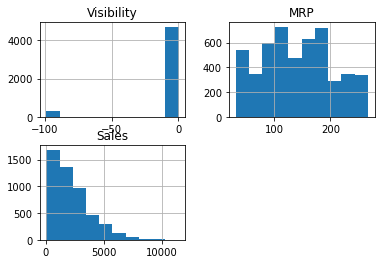

In [11]:
# Lager histogrammer for de numeriske variablene

frame.hist()

In [12]:
# Sjekker verdiene i den kategoriske variabelen
frame["FatContent"].value_counts(dropna=False)

Low Fat    3008
Regular    1679
LF          183
reg          68
low fat      62
Name: FatContent, dtype: int64

In [13]:
# Sjekker verdiene i den kategoriske variabelen
frame["StoreType"].value_counts(dropna=False)

Supermarket Type1    3328
Grocery Store         608
Supermarket Type3     538
Supermarket Type2     526
Name: StoreType, dtype: int64

In [14]:
# Sjekker verdiene i den kategoriske variabelen
frame["SizeStore"].value_counts(dropna=False)

Medium    1605
NaN       1439
Small     1398
High       558
Name: SizeStore, dtype: int64

In [15]:
# Sjekker egeneskapene til produktkoden
frame["ProductID"].value_counts(dropna=False)

DRE49    8
FDU23    8
FDR43    8
FDJ55    8
NCR53    7
        ..
FDZ55    1
FDR16    1
FDS07    1
FDO31    1
FDS36    1
Name: ProductID, Length: 1538, dtype: int64

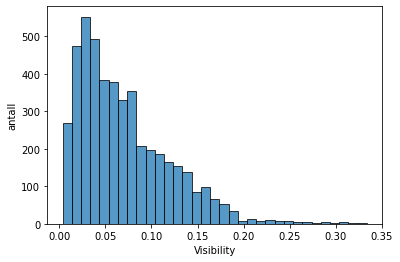

In [16]:
# Utforsker fordelingen på "synlighet" uten outliers
make_histogram(frame[frame["Visibility"]!=-99], "Visibility", .01)

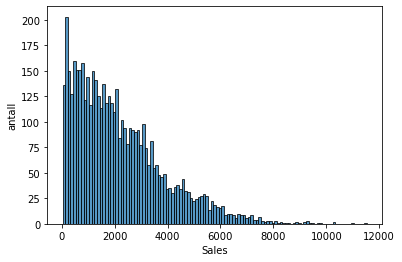

In [17]:
# Utforsker fordelingen på den avhengige variabelen "Sales"
make_histogram(frame, "Sales", 100)

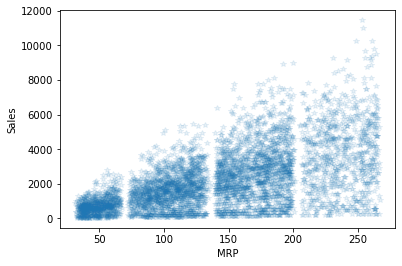

In [18]:
make_scatter_plot(frame, "MRP", "Sales")

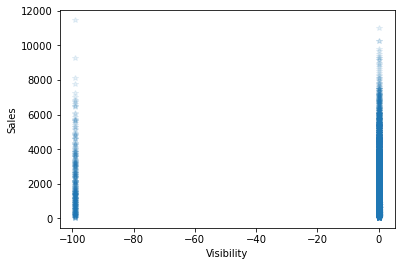

In [19]:
make_scatter_plot(frame, "Visibility", "Sales")

***

_**Oppgaver**:_

5. _Du bør nå ha funnet minst to (vi vet om tre) datakvalitetsproblemer. Beskriv dem._
6. _Du kan komme deg rundt et av datakvalitetsproblemene ved å rette opp det som er feil, hvis du har gode grunner til å anta hva det skal rettes til. Hvis du ikke kan gjøre noen slike antagelser, kan du fylle inn gjennomsnittet eller den mest vanlige verdien. Du kan også velge å fjerne alle rader med et gitt datakvalitetproblem. For hver av datakvalitetsproblemene, velg en strategi og begrunn hvorfor._
7. _Du skal ta vekk kolonnen for ProductID. Kan du forklare hvorfor?_

>**Hint 1**: To av problemene har med manglende verdier å gjøre, og ett har med skrivemåter å gjøre.
>
>**Hint 2**:
Nyttige pandas-funksjoner:
>```
># Erstatt et ord med et annet. Kan også brukes for numeriske verdier.
>frame[variabel].replace({"ord1":"nyttord1","ord2":"nyttord2"},inplace=True)
>
># Erstatt NaN-verdier
>frame[variabel].fillna(<tall eller ord som erstatter NaN>,inplace=True)
>
># Ta vekk alle datapunkter som ikke tilfredstiller et krav
>frame=frame[frame[variabel]!=4]
>
># Dropp alle kolonner som inneholder NaN
>frame.dropna(inplace=True)
>
># Dropp en kolonne
>frame.drop(columns=[variabel],inplace=True)
>```

**Svar**:

5.<br>
Det er flere problemer med datasettet:

 - "Visibility" er oppgitt som en verdi mellom 0 og 1, men har mange med verdi -99. 
 - "SizeStore" har en stor andel manglende verdier.
 - "FatContent" har 5 ulike verdier, men de skiller seg bare på stavemåte. Egentlig er det bare 2 kategorier: 
           1. Low Fat, LF, low fat
           2. Regular, reg
            
6.<br>
Valg av strategi for korreksjoner:

 - "Visibility": Her kan man velge å droppe radene eller erstatte (-99) med gjennomsnitt. En alternativ strategi vil være å sette verdien til 0 for disse radene, under antakelsen om at det er den riktige verdien.
    <br> Jeg velger å droppe radene fordi de utgjør en liten andel av datasettet.

-  "SizeStore": Manglende verdier kan settes til kategori "Unknown". Alternativt kan man fjerne disse radene, eller rett og slett droppe kolonnen. Alternative strategier kan være å sette kategorien til den mest vanlige kategorien. Et annet alternativ kan være å undersøke de øvrige variablene for disse radene nærmere for å se om de har noe til felles.
     <br> Jeg velger å innføre en ny kategori "Unknown". Det er fordi jeg ikke ønsker å fjerne en så stor del av datasettet. Dessuten er det uklart hvilken grad denne variabelen har stor prediktiv styrke.

 -  "FatContent": Her er det naturlig å korrigere ved å slå sammen verdiene som betyr det samme. Antar at verdiene skiller seg kun på ulik stavemåte
     <br> Jeg velger derfor å korrigere, slik at vi stter igjen med kun 2 distinkte kategorier.


7.<br>
Fjerne kollonnen "ProductID"
<br> ProductId er kode-verdier, som tilsynelatende ikke er meningsbærende. Det er veldig mange ulike verdier, og svært mange av dem er representert bare 1 gang.
ProductID vil også gjøre det problematisk one-hot-encoding. Og siden mange ProductID'er forekommer kun én gang vil mange ikke være representert i treningsdataene.

***


# Studentkode
# Den bruker Pearsons korrelasjonskoeffisient.
corr_heatmap(frame.corr())### Sjekk korrelasjoner
_**Kodeoppgave**:_
- _Sjekk korrelasjoner mellom den avhengige og de uavhengige variabelene._

> **Hint 1**: For å finne korrelasjoner mellom numeriske variabler, er det standard å bruke Pearsons korrelasjonskoeffisient. Denne metoden finner kun linære sammenhenger, men er et godt utgangspunkt. Se notebook i modul 1 for kode.
>
> **Hint 2**: For å finne korrelasjoner mellom kategoriske variabler og den avhengige variabelen, har vi ikke en like god standard. Men en enkel måte å se om en kategorisk variabel påvirker den avhengige variabelen, er å lage et såkalt boksplott for variabelen og se nærmere på de enkelte kategoriene. Generelt viser et slikt boksplott hvordan verdier i et utvalg fordeler seg, med maksverdi, minverdi, medianverdi, 25-persentil og 75-persentil. I vårt tilfelle kan vi tegne opp kategoriene for hver uavhengig variabel, stilt opp mot den avhengige variabelen _Sales_. Hvis vi ser at distribusjonen til _Sales_-dataene for en uavhengig variabel er ganske ulik for de forskjellige kategoriene, er det sannsynlig at denne variabelen påvirker _Sales_.
>
> **Hint 3**: Her er et eksempel på hvordan man lager boksplott for de forskjellige butikkstørrelsene:
>```
>sns.boxplot(x="SizeStore", y="Sales", data=frame)
>```

<AxesSubplot:title={'center':'Correlation matrix'}>

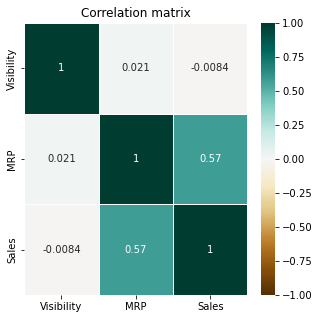

In [20]:
# Sjekker korrelasjon mellom numeriske variable ved bruk av Pearsons korrelasjonskoeffisient.
corr_heatmap(frame.corr(), figsize=(5, 5))

<AxesSubplot:xlabel='SizeStore', ylabel='Sales'>

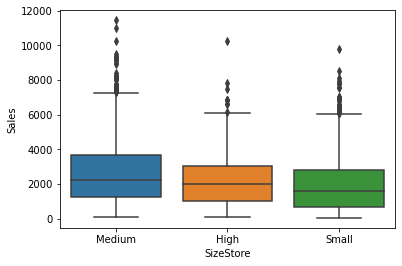

In [21]:
# Sjekker korellasjon mellom kategorisk variabel og den avhengige variabelen
sns.boxplot(x="SizeStore", y="Sales", data=frame)

<AxesSubplot:xlabel='StoreType', ylabel='Sales'>

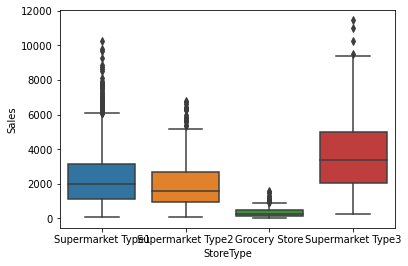

In [22]:
# Sjekker korellasjon mellom kategorisk variabel og den avhengige variabelen
sns.boxplot(x="StoreType", y="Sales", data=frame)

<AxesSubplot:xlabel='FatContent', ylabel='Sales'>

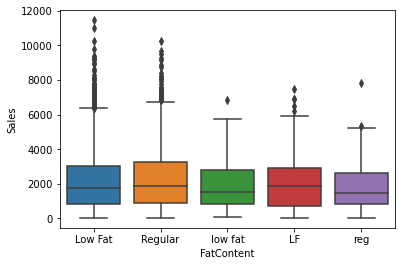

In [23]:
# Sjekker korellasjon mellom kategorisk variabel og den avhengige variabelen
sns.boxplot(x="FatContent", y="Sales", data=frame)

***

_**Oppgave**:_

8. _Hvilke variabler tror du kan komme til å påvirke salget basert på den analysen du har gjort? Begrunn svaret ditt._

**Svar**:

 - StoreType har trolig stor betydning siden boxplottet viser at de ulike kategoriene gir svært ulikt salg.

 - SizeStore har trolig liten eller ingen betydning, siden boxplottet viser at de ulike verdiene ikke ser ut til å gi særlig forskjellig salg.

 - Visibility har svært lav korellasjon (-0.0084) med Sales, og antas derfor å ha lav påvirkning.

 - MRP ser ut for å ha en betydelig korrelert (0.5) med Sales. Men her er det stor usikkerhet, fordi MRP uttrykker en maks-pris og ikke den reelle prisen produktet ble solgt for. Og det er ikke unaturlig at  Sales at høy enhetspris henger sammen med totalsalg.

Basert på analysen så langt ser det ut til at StoreType og MRP er de variabelen som har størst påvirkning på salget, mens Visibility har lav betydning.
<br>
<br>

***


## Modell

Du skal nå trene en modell som bruker informasjon om et produkt og en butikk til å predikere salget av det produktet i den butikken. Du skal benytte XGBoost og kan starte med å bruke alle de uavhenige variablene (unntatt ProductID, som du allerede har utelukket). Notebook 2 fra modul 2 inneholder både forklaring og eksempel på bruk av XGBoost. Før du trener modellen, må du splitte opp dataene og preprossere dem.

_**Kodeoppgave**:_
- _Del inn i trenings- og valideringsdata, og gjør preprosessering av data._

> **Hint**: Tenk på hvilke typer av preprosessering du trenger å gjøre på dataene. Beskrivelse av preprosessering finner du i notebooken til modul 3. I dette tilfellet er det helt greit å gjøre en-hot-koding (one-hot encoding) med den enkle koden vist nedenfor. Det er også greit å gjøre det før du deler opp data, fordi vi antar at alle kategorier vil være representert i både trenings-, validerings- og testdataene.
>```
>frame_processed=pd.get_dummies(frame)
>```

In [24]:
frame.shape

(5000, 7)

In [25]:
# Dropp kolonnen ProductId
frame.drop(columns=["ProductID"],inplace=True)

In [26]:
frame.shape

(5000, 6)

In [27]:
# Ta vekk alle datapunkter som ikke tilfredstiller et krav
frame=frame[frame["Visibility"] != -99]

In [28]:
frame.shape

(4695, 6)

In [29]:
# FatContent. Korrigere data for ulike stavemåte
frame["FatContent"].replace({"LF":"Low Fat","low fat":"Low Fat"},inplace=True)
frame["FatContent"].replace({"reg":"Regular"},inplace=True)
frame["FatContent"].value_counts(dropna=False)

Low Fat    3047
Regular    1648
Name: FatContent, dtype: int64

In [30]:
# SizeStore. Håndtere tomme verdier ved å merke dem som en ny kategori
frame["SizeStore"].fillna("Unknown",inplace=True)

In [31]:
frame["SizeStore"].value_counts(dropna=False)

Medium     1504
Unknown    1352
Small      1316
High        523
Name: SizeStore, dtype: int64

In [32]:
frame.head()

,FatContent,Visibility,StoreType,SizeStore,MRP,Sales
0,Low Fat,0.016047,Supermarket Type1,Medium,249.8092,3735.1380
1,Regular,0.019278,Supermarket Type2,Medium,48.2692,443.4228
2,Low Fat,0.016760,Supermarket Type1,Medium,141.6180,2097.2700
6,Regular,0.012741,Supermarket Type1,High,57.6588,343.5528
7,Low Fat,0.127470,Supermarket Type3,Medium,107.7622,4022.7636


In [33]:
# One-hot-encoding for de kategoriske variablene
frame_processed=pd.get_dummies(frame)

In [34]:
frame_processed.shape

(4695, 13)

In [35]:
frame_processed.head()

,Visibility,MRP,Sales,FatContent_Low Fat,FatContent_Regular,StoreType_Grocery Store,StoreType_Supermarket Type1,StoreType_Supermarket Type2,StoreType_Supermarket Type3,SizeStore_High,SizeStore_Medium,SizeStore_Small,SizeStore_Unknown
0,0.016047,249.8092,3735.1380,1,0,0,1,0,0,0,1,0,0
1,0.019278,48.2692,443.4228,0,1,0,0,1,0,0,1,0,0
2,0.016760,141.6180,2097.2700,1,0,0,1,0,0,0,1,0,0
6,0.012741,57.6588,343.5528,0,1,0,1,0,0,1,0,0,0
7,0.127470,107.7622,4022.7636,1,0,0,0,0,1,0,1,0,0


In [36]:
# Lager liste på de uavhengige variablene (X)
X_feat = ['Visibility', 'MRP','FatContent_Low Fat','FatContent_Regular','StoreType_Grocery Store','StoreType_Supermarket Type1','StoreType_Supermarket Type2','StoreType_Supermarket Type3','SizeStore_High','SizeStore_Medium','SizeStore_Small','SizeStore_Unknown']

# Den uavhengige variabelen (y)
y_feat = ['Sales']

# Splitter datasettet i trening (80%) vs validering (20%)
X_train, X_val, y_train, y_val = train_test_split(frame_processed[X_feat], frame_processed[y_feat], test_size=0.2, random_state=109) 

In [37]:
X_train.shape

(3756, 12)

In [38]:
X_val.shape

(939, 12)

In [39]:
y_train.shape

(3756, 1)

In [40]:
y_val.shape

(939, 1)

In [41]:
X_train.head()

,Visibility,MRP,FatContent_Low Fat,FatContent_Regular,StoreType_Grocery Store,StoreType_Supermarket Type1,StoreType_Supermarket Type2,StoreType_Supermarket Type3,SizeStore_High,SizeStore_Medium,SizeStore_Small,SizeStore_Unknown
4868,0.166573,176.1712,1,0,0,0,0,1,0,1,0,0
1936,0.066555,80.8960,0,1,0,1,0,0,0,0,0,1
3224,0.153128,162.4894,1,0,1,0,0,0,0,0,0,1
1023,0.054566,152.2366,0,1,0,1,0,0,0,0,0,1
1380,0.039386,224.8404,0,1,1,0,0,0,0,0,0,1


In [42]:
y_train.head()

,Sales
4868,3691.1952
1936,958.7520
3224,323.5788
1023,2418.1856
1380,1575.2828


In [43]:
X_val.head()

,Visibility,MRP,FatContent_Low Fat,FatContent_Regular,StoreType_Grocery Store,StoreType_Supermarket Type1,StoreType_Supermarket Type2,StoreType_Supermarket Type3,SizeStore_High,SizeStore_Medium,SizeStore_Small,SizeStore_Unknown
215,0.150555,130.0626,0,1,1,0,0,0,0,0,0,1
3695,0.061156,228.4010,1,0,1,0,0,0,0,0,0,1
1568,0.049017,128.7336,1,0,0,1,0,0,0,1,0,0
2977,0.118828,75.0696,1,0,1,0,0,0,0,0,0,1
1619,0.056019,40.0454,1,0,0,0,0,1,0,1,0,0


In [44]:
y_val.head()

,Sales
215,131.1626
3695,229.7010
1568,2173.1712
2977,149.1392
1619,419.4540


In [45]:
X_val.shape

(939, 12)

In [46]:
y_val.shape

(939, 1)

In [47]:
# Feature scaling funksjoner
sc_X = MinMaxScaler(feature_range=[0,1])
sc_y = MinMaxScaler(feature_range=[0,1])

# Skalerer/Normaliserer de numeriske verdiene
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train.values), columns=X_feat)
y_train_scaled = pd.DataFrame(sc_y.fit_transform(y_train.values), columns=y_feat)
X_val_scaled   = pd.DataFrame(sc_X.transform(X_val.values), columns=X_feat)
y_val_scaled   = pd.DataFrame(sc_y.transform(y_val.values), columns=y_feat)

In [48]:
X_train_scaled.shape

(3756, 12)

In [49]:
X_train_scaled.head()

,Visibility,MRP,FatContent_Low Fat,FatContent_Regular,StoreType_Grocery Store,StoreType_Supermarket Type1,StoreType_Supermarket Type2,StoreType_Supermarket Type3,SizeStore_High,SizeStore_Medium,SizeStore_Small,SizeStore_Unknown
0,0.501793,0.614950,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.193860,0.210553,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.460399,0.556877,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.156947,0.513359,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.110211,0.821527,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
y_train_scaled.head()

,Sales
0,0.333698
1,0.084381
2,0.026426
3,0.217544
4,0.140635


### XGBoost-modell
Når du nå skal lage en XGBoost-modell, kan du starte med å bruke standardverdier for flest mulig av hyperparameterene. Det eneste du skal ta stilling til, er dybden på træerne og evalueringsmetrikken. Her er et kode-eksempel uten hyperparameter-verdier:
```
params = {'max_depth': , 'objective': }
xgb_model = xgb.train(params=params, 
                       dtrain=xgb.DMatrix(X_train, label=y_train))
predicted = xgb_model.predict(xgb.DMatrix(X_eval))
```

_**Kodeoppgave**:_
- _Plott prediksjonene og y_eval for å sjekke at modellen predikerer meningsfylt._

> Hint: Du kan f.eks. bruke følgende kode:
> ```
> x = range(len(y_eval))
> plt.scatter(x, y_eval, label='y_eval')
> plt.scatter(x, predicted, label='predicted')
> plt.legend()
> ```

In [51]:
# Definer en XGBoost modell, og trener den opp. I første omgang med default verdier på parametrene.
params = {'learning_rate': 0.3, 'max_depth': 3, 'min_split_loss': 0.0, 'num_parallel_tree': 4, 'objective':'reg:squarederror'}
xgb_model = xgb.train(params=params, 
                      dtrain=xgb.DMatrix(X_train_scaled, label=y_train_scaled))



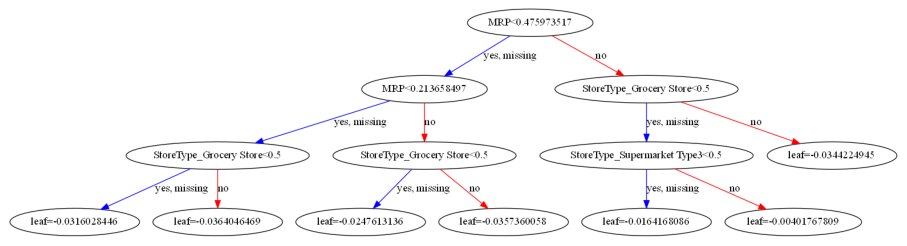

In [52]:
# Tegner opp et eksempel-tre for illustrasjon
plt.rcParams['figure.figsize'] = [16, 8]
xgb.plot_tree(xgb_model, num_trees=1)
plt.show()

In [53]:
# Bruke modellen til å gi en prediksjon for valideringsdata
y_pred_scaled = xgb_model.predict(xgb.DMatrix(X_val_scaled)).reshape(-1, 1)

# Skalere tilbake til Rupi-verdier
y_pred = pd.DataFrame(sc_y.inverse_transform(y_pred_scaled), columns=y_feat)  # Rescaling

In [54]:
y_pred.head()

,Sales
0,551.765442
1,775.096924
2,2179.150635
3,431.247437
4,1232.045654


In [55]:
y_val.head()

,Sales
215,131.1626
3695,229.7010
1568,2173.1712
2977,149.1392
1619,419.4540


In [56]:
y_val_scaled.head()

,Sales
0,0.008869
1,0.017860
2,0.195189
3,0.010510
4,0.035174


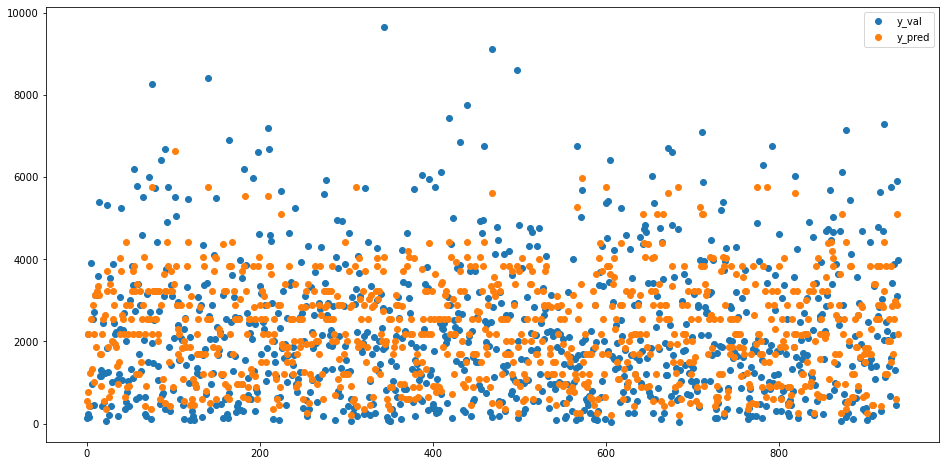

In [57]:
# Plott prediksjonen sammenholdt med valideringsdata for å sjekke at modellen predikerer meningsfylt.

x = range(len(y_val))
plt.scatter(x, y_val, label='y_val')
plt.scatter(x, y_pred, label='y_pred')
plt.legend()

## Modell-evaluering
_**Kodeoppgave**:_
- _Evaluer modellen din med RMSE og R2._

> Hint: Du kan benytte funksjonene `mean_squared_error` og `r2_score` fra scikit-learn som vi lastet inn på starten. Se eksempler i modul 3.

In [58]:
# Evaluere mot Baseline (gjennomsnitt)
print("RMSE: ", np.sqrt(mean_squared_error(y_val, [y_train.mean()]*len(y_val))))
print("R2: ", r2_score(y_val, [y_train.mean()]*len(y_val)))

RMSE:  1693.2440493365589
R2:  -9.103475512617365e-05


In [59]:
# RMSE modell vs valideringsdata: 
print("RMSE validering: ", np.sqrt(mean_squared_error(y_val,y_pred)))

# RMSE modell vs treningsdata: 
y_train_pred_scaled = xgb_model.predict(xgb.DMatrix(X_train_scaled)).reshape(-1, 1)
y_train_pred = pd.DataFrame(sc_y.inverse_transform(y_train_pred_scaled), columns=y_feat)  # Rescaling
print("RMSE trening: ", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# R2 modell vs valideringsdata: 
print("R2 validering: ", r2_score(y_val, y_pred))

# R2 tmodell vs reningsdata: 
print("R2 trening: ", r2_score(y_train, y_train_pred))

RMSE validering:  1046.106604499304
RMSE trening:  1072.5469090241743
R2 validering:  0.6182735037903146
R2 trening:  0.5985260314783045


***

### Parameter-tuning
Underveis i utprøveing av xboost har jeg erfart at learning_rate har svært stor innvirkning på resultatet.

 - learning_rate kan settes for å styre hvor stor vektingen av hvert nye tre når det tas inn i læringsprosessen. Tar verdier mellom 0 og 1. Default verdi er 0.3.

Jeg ønsker her å undersøke hvordan ulike verdier av learning_rate slår ut for min modell.


In [60]:
# Parameter-tuning: Undersøker ulike verdier på learning rate
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1.0]

for l_rate in learning_rate:

    params = {'learning_rate': l_rate, 'max_depth': 3, 'min_split_loss': 0.0, 'num_parallel_tree': 3, 'objective':'reg:squarederror'}
    
    # Re-train
    xgb_model = xgb.train(params=params, dtrain=xgb.DMatrix(X_train_scaled, label=y_train_scaled))

    # Prediksjon og skalering
    y_pred_scaled = xgb_model.predict(xgb.DMatrix(X_val_scaled)).reshape(-1, 1)
    y_pred = pd.DataFrame(sc_y.inverse_transform(y_pred_scaled), columns=y_feat)  # Rescaling

    # Måleresultat
    print("learning_rate = ", l_rate, " Resultat: ", "RMSE: ", np.sqrt(mean_squared_error(y_val,y_pred)), " R2: ",r2_score(y_val, y_pred) )



learning_rate =  0.0001  Resultat:  RMSE:  3719.912220645472  R2:  -3.8268722175844836
learning_rate =  0.001  Resultat:  RMSE:  3689.6287180787895  R2:  -3.7486017688173563
learning_rate =  0.01  Resultat:  RMSE:  3401.3054804635785  R2:  -3.0354474453880522
learning_rate =  0.1  Resultat:  RMSE:  1651.812096908932  R2:  0.04825259210362964
learning_rate =  0.2  Resultat:  RMSE:  1119.5127346975169  R2:  0.5628218033030454
learning_rate =  0.25  Resultat:  RMSE:  1059.0183290711334  R2:  0.608792320411675
learning_rate =  0.3  Resultat:  RMSE:  1046.1065639822857  R2:  0.6182735333598042
learning_rate =  0.35  Resultat:  RMSE:  1042.2947235121446  R2:  0.6210503620445847
learning_rate =  0.4  Resultat:  RMSE:  1043.1498324915503  R2:  0.6204283188642894
learning_rate =  0.45  Resultat:  RMSE:  1042.0070237299656  R2:  0.6212595325971748
learning_rate =  0.5  Resultat:  RMSE:  1043.5285010565535  R2:  0.6201526960399861
learning_rate =  0.55  Resultat:  RMSE:  1047.4038138293436  R2:  

Resultatet viser stor variasjon på ytelse avhengig av hvilken learning rate vi velger.

Jeg tenker at Learning Rate bør settes til 0.45 for å optimere ytelsen på modellen. Trener derfor modellen på nytt med denne verdien:

In [61]:
params = {'learning_rate': 0.45, 'max_depth': 3, 'min_split_loss': 0.0, 'num_parallel_tree': 3, 'objective':'reg:squarederror'}

# Re-train
xgb_model = xgb.train(params=params, dtrain=xgb.DMatrix(X_train_scaled, label=y_train_scaled))

# Prediksjon og skalering
y_pred_scaled = xgb_model.predict(xgb.DMatrix(X_val_scaled)).reshape(-1, 1)
y_pred = pd.DataFrame(sc_y.inverse_transform(y_pred_scaled), columns=y_feat)  # Rescaling

# Måleresultat
print(" Resultat: ", "RMSE: ", np.sqrt(mean_squared_error(y_val,y_pred)), " R2: ",r2_score(y_val, y_pred) )

 Resultat:  RMSE:  1042.0070237299656  R2:  0.6212595325971748


_**Oppgaver**:_

9. _Beskriv minst én fordel og én ulempe ved XGBoost._
10. _Forklar forskjellen på RMSE og R2._
11. _Fungerte modellen like godt på valideringsdataene som på treningsdataene? Hvis ikke, forklar hvorfor. Kan du bruke dette til å forbedre modellen?_ 

**Svar**:

9.<br>
XGBoost er en ensemble metode som bygger på descision trees. Algoritmen bygger et sett med beslutningstrær, hvor hvert tre nytt tre blir evaluert med bruk av en tapsfunksjon (loss). Strategien er å forbedre modellen ved å minimere tap.

Fordelen med XGBoost er det er modell med god ytelse og er relativt lett å bruke. Implementasjonen har også rask utførelse.

Ulempene er at modellen blir lite forklarbar, dvs den er "Black box" og vanskelig å gi en forståelig forklaring på prediksjonen. En annen ulempe er at denne modellen håndterer kun 1 output variabel.
 
 
10.<br>
Evalueringsmetrikker:

RMSE - <i>Root Mean Squared Error </i> - er en metrikk for avviket mellom predikert verdi og faktisk verdi. Lav verdi betyr at predikert verdi ligger nært faktisk, mens høy verdi betyr at prediksjonen er dårlig.

R2 - <i>R Squared </i> - er en metrikk for varians i prediksjonen:
 - 1.0 er perfekt prediksjon
 - 0.0 oppnås ved å predikere et gjennomsnitt (baseline)
 - negative verdier indikerer at modell gir en dårlig prediksjon
 
<br>

11.  Treningsdata vs alideringsdata
<br> 

Ved å regne ut RMSE og R2 både for trenings- og valideringsdata kan man evaluere modellen. Mine mål er regnet ut ovenfor.

Viser at modellen slik den er nå viser at den predikerer bedre enn baseline, men ligger fortsatt et stykke unna valideringsdataene.
 - Vurderer at RMSE er noe høy i RUPI, noe som indikerer at prediksjonen fortsatt ligger et stykke fra faktisk verdi.
 - Vurderer at R2 slik det ligger nå (0.62) er relativt bra.

***


### Eksperimenter med å ta vekk variabler
_**Kodeoppgave**:_
- _Forsøk å ta vekk variabler du tror ikke er signifikante basert på den utforskende analysen._

> Hint: Du finner eksempler i modul 3.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

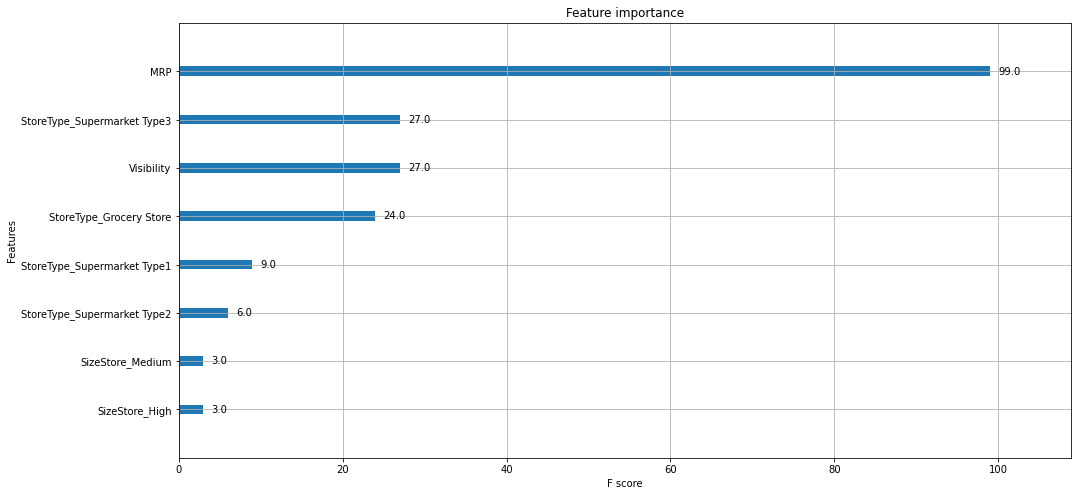

In [62]:
# Undersøker hvilke variable og kategorier som statistisk skal ha størst påvirking.
xgb.plot_importance(xgb_model, ax=plt.gca())

In [63]:
# Lager en redusert liste på de uavhengige variablene.
X_feat_reduced = ['MRP', 'StoreType_Grocery Store','StoreType_Supermarket Type1','StoreType_Supermarket Type2','StoreType_Supermarket Type3']
X_train_reduced = X_train[X_feat_reduced]
X_val_reduced = X_val[X_feat_reduced]


In [64]:
X_train_reduced.head()

,MRP,StoreType_Grocery Store,StoreType_Supermarket Type1,StoreType_Supermarket Type2,StoreType_Supermarket Type3
4868,176.1712,0,0,0,1
1936,80.8960,0,1,0,0
3224,162.4894,1,0,0,0
1023,152.2366,0,1,0,0
1380,224.8404,1,0,0,0


In [65]:
# Skalerer/Normaliserer de numeriske verdiene
X_train_reduced_scaled = pd.DataFrame(sc_X.fit_transform(X_train_reduced.values), columns=X_feat_reduced)
X_val_redused_scaled = pd.DataFrame(sc_X.transform(X_val_reduced.values), columns=X_feat_reduced)


In [66]:
X_train_reduced_scaled.head()

,MRP,StoreType_Grocery Store,StoreType_Supermarket Type1,StoreType_Supermarket Type2,StoreType_Supermarket Type3
0,0.614950,0.0,0.0,0.0,1.0
1,0.210553,0.0,1.0,0.0,0.0
2,0.556877,1.0,0.0,0.0,0.0
3,0.513359,0.0,1.0,0.0,0.0
4,0.821527,1.0,0.0,0.0,0.0


In [67]:
# Definer en ny XGBoost modell for redusert variabelliste, og trener den opp
params = {'learning_rate': 0.45, 'max_depth': 3, 'min_split_loss': 0.0, 'num_parallel_tree': 3, 'objective':'reg:squarederror'}
xgb_model_reduced = xgb.train(params=params, dtrain=xgb.DMatrix(X_train_reduced, label=y_train_scaled))


In [68]:
# Bruke modellen til å gi en prediksjon for valideringsdata
y_pred_scaled_reduced = xgb_model_reduced.predict(xgb.DMatrix(X_val_reduced)).reshape(-1, 1)

# Skalere tilbake til Rupi-verdier
y_pred_reduced = pd.DataFrame(sc_y.inverse_transform(y_pred_scaled_reduced), columns=y_feat)  # Rescaling

In [69]:
y_pred_reduced.head()

,Sales
0,422.690247
1,578.507263
2,1984.296265
3,155.506668
4,1165.952393


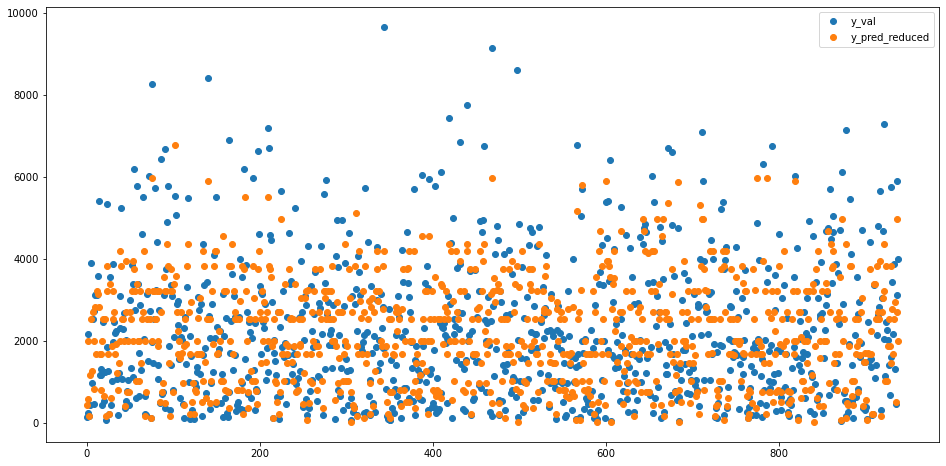

In [70]:
# Plotte ny prediksjonen sammenholdt med valideringsdata for å sjekke at modellen predikerer meningsfylt.

x = range(len(y_val))
plt.scatter(x, y_val, label='y_val')
plt.scatter(x, y_pred_reduced, label='y_pred_reduced')
plt.legend()

In [71]:
# RMSE modell vs valideringsdata: 
print("RMSE validering: ", np.sqrt(mean_squared_error(y_val,y_pred_reduced)))

# R2 modell vs valideringsdata: 
print("R2 validering: ", r2_score(y_val, y_pred_reduced))


RMSE validering:  1039.8151941653268
R2 validering:  0.6228511945604953


***

_**Oppgaver**:_

12. _Bør du ta vekk variablene som du tenkte ikke var signifikante?_
13. _Hva kan gjøres for å forbedre modellen? Beskriv med ord._

**Svar**:

12. ikke-signifikante variable

Jeg har regnet ut kvalitetsmål etter å har redusert variabel-listen til kun 'MRP' og 'StoreType', vist i cellen ovenfor.

Vi ser ytelsen blir litt bedre med redusert variabelsett, ved at RMSE blir litt lavere. Men det ser ikke ut til å være en vesentlig forskjell. Jeg vurdere at de likevel bør tas bort siden ytelsen da blir bedre.

 
13. Mulige forbedringer

Jeg ser noen muligheter som jeg ikke har undersøkt fullt ut:
 - Revurdere strategi med hensyn til preprosesseringen og korrigeringene. Her kan det tenkes at de alternative strategiene som ble nevnt i Oppgave 6. Særlig strategien med ny kategori for SizeStore en kandidat for videre undersøkelse.
 
 - Parameteren Max_depth og min_split_loss kan også virke innpå modellens ytelse, og kan undersøkes på samme måte som jeg gjorde med learing_rate.

 
<br>

***
